$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [87]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [88]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/tal.yaakov/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/tal.yaakov/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/tal.yaakov/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [89]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


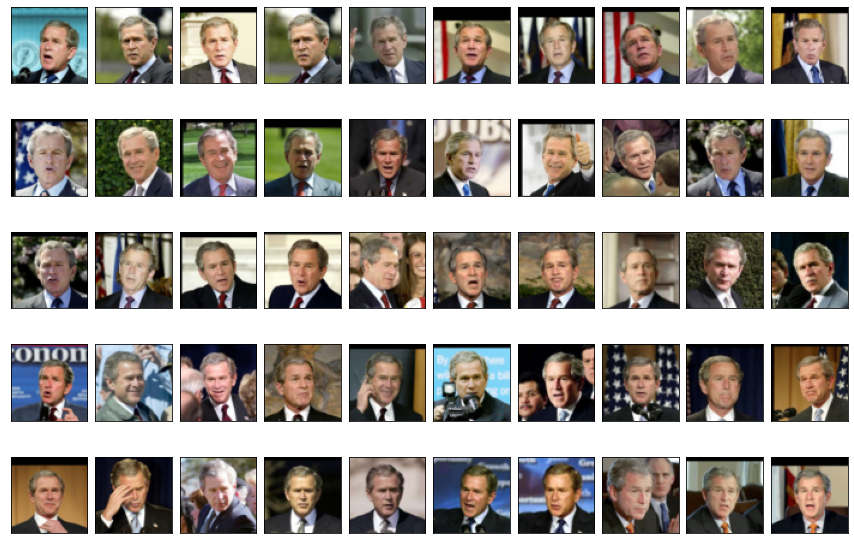

In [90]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [91]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [92]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.3, inplace=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout(p=0.3, inplace=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Dropout(p=0.3, inplace=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=64, stride=64, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [93]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.6, inplace=False)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(4, 4))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.6, inplace=False)
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(4, 4))
    (7): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [94]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [95]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223, dtype=torch.float64)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

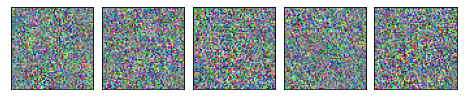

In [96]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [97]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.25, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0002}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
Discriminator loss: 0.18157880670494503
Generator loss:     2.0580889227213297
Saved checkpoint.


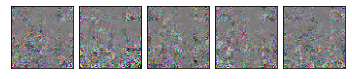

--- EPOCH 2/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
Discriminator loss: 0.1369737924800979
Generator loss:     2.0522091844383694


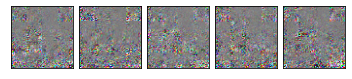

--- EPOCH 3/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
Discriminator loss: 0.05971706244680616
Generator loss:     2.1054801367200504


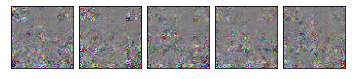

--- EPOCH 4/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
Discriminator loss: 0.10485664755105972
Generator loss:     2.0994178474632963


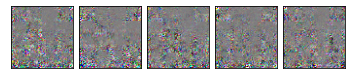

--- EPOCH 5/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
Discriminator loss: 0.09067971838845147
Generator loss:     2.1761199027609672


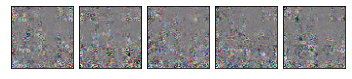

--- EPOCH 6/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
Discriminator loss: 0.15346270634068382
Generator loss:     2.1434196440305917


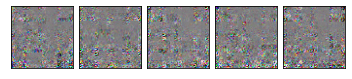

--- EPOCH 7/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
Discriminator loss: 0.12244272149271435
Generator loss:     2.2138361447900157


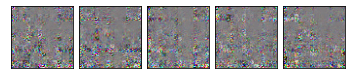

--- EPOCH 8/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
Discriminator loss: 0.05499959488709768
Generator loss:     2.237939583335699


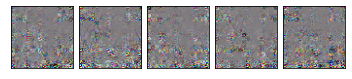

--- EPOCH 9/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
Discriminator loss: 0.17326298356056213
Generator loss:     2.1375801772590375


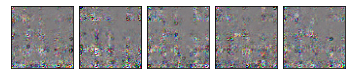

--- EPOCH 10/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
Discriminator loss: 0.15749114089541966
Generator loss:     2.2659522878856673


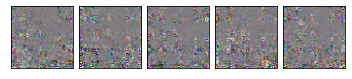

--- EPOCH 11/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
Discriminator loss: 0.10994997206661436
Generator loss:     2.3307180889003365


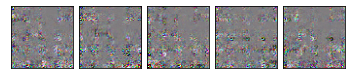

--- EPOCH 12/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
Discriminator loss: 0.12419349824388821
Generator loss:     2.388688214414497


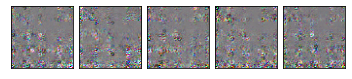

--- EPOCH 13/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
Discriminator loss: 0.11413994762632582
Generator loss:     2.4113922484634553


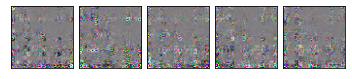

--- EPOCH 14/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
Discriminator loss: 0.04178894807895025
Generator loss:     2.3739560656280636


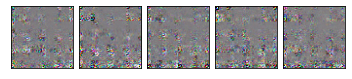

--- EPOCH 15/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
Discriminator loss: -0.004678578012519413
Generator loss:     2.461424108555163


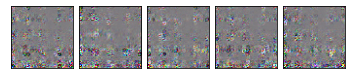

--- EPOCH 16/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
Discriminator loss: 0.07992828099264039
Generator loss:     2.365045107241744


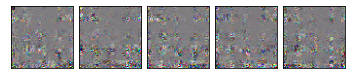

--- EPOCH 17/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
Discriminator loss: 0.16542024082607693
Generator loss:     2.4932562966673135


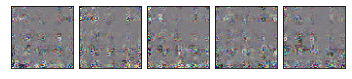

--- EPOCH 18/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
Discriminator loss: 0.16128451377153397
Generator loss:     2.5274148622653168


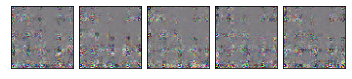

--- EPOCH 19/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
Discriminator loss: 0.13915324790610206
Generator loss:     2.513419868923035


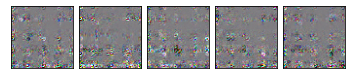

--- EPOCH 20/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.05it/s]
Discriminator loss: 0.12261577530039681
Generator loss:     2.5904043410192505


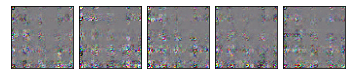

--- EPOCH 21/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
Discriminator loss: 0.08215224908457862
Generator loss:     2.6479972385804698


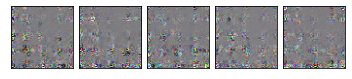

--- EPOCH 22/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
Discriminator loss: 0.06839974638488558
Generator loss:     2.6864231753799057


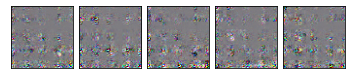

--- EPOCH 23/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
Discriminator loss: -0.0025205519050359726
Generator loss:     2.6883018033950044


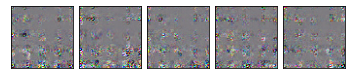

--- EPOCH 24/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
Discriminator loss: 0.08545047210322486
Generator loss:     2.649287119591178


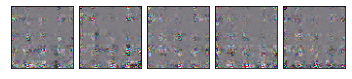

--- EPOCH 25/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
Discriminator loss: 0.08186044543981552
Generator loss:     2.770183925697306


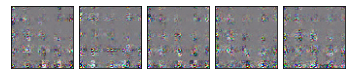

--- EPOCH 26/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.71it/s]
Discriminator loss: 0.07768272711998886
Generator loss:     2.7702473374437844


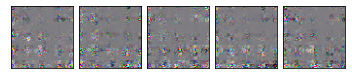

--- EPOCH 27/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
Discriminator loss: 0.1046966306037373
Generator loss:     2.8456550217833714


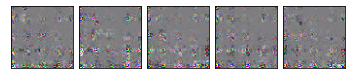

--- EPOCH 28/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
Discriminator loss: 0.08083879699309666
Generator loss:     2.8612266771028385


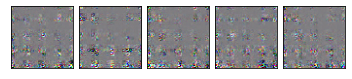

--- EPOCH 29/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
Discriminator loss: 0.033222089211146034
Generator loss:     2.942473857459044


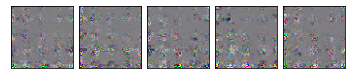

--- EPOCH 30/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
Discriminator loss: 0.18668663998444876
Generator loss:     2.7217042045656985


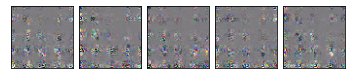

--- EPOCH 31/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
Discriminator loss: 0.09955179049736923
Generator loss:     2.9576776974126995


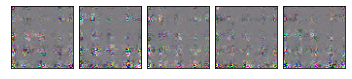

--- EPOCH 32/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.95it/s]
Discriminator loss: 0.11329371647702323
Generator loss:     2.9387487709028517


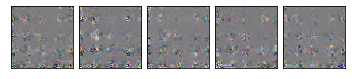

--- EPOCH 33/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
Discriminator loss: 0.12094072169727749
Generator loss:     2.8754816831778363


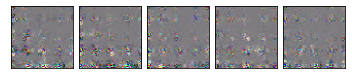

--- EPOCH 34/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
Discriminator loss: -0.045308696726957955
Generator loss:     2.9741386709965982


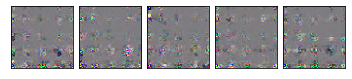

--- EPOCH 35/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
Discriminator loss: -0.04514644708898333
Generator loss:     3.0291044155137943


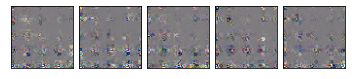

--- EPOCH 36/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.59it/s]
Discriminator loss: 0.11054962873458862
Generator loss:     3.0404242815991758


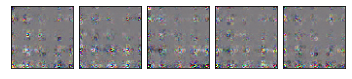

--- EPOCH 37/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: -0.01184554791284932
Generator loss:     3.073317461863142


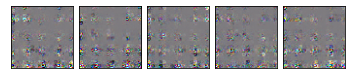

--- EPOCH 38/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
Discriminator loss: 0.11595387756824493
Generator loss:     3.1497669533029558


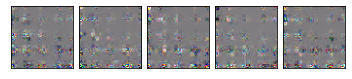

--- EPOCH 39/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.65it/s]
Discriminator loss: 0.0908538012040986
Generator loss:     3.0823910748791903


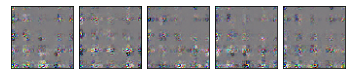

--- EPOCH 40/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
Discriminator loss: 0.1205965235001511
Generator loss:     3.0238415995545442


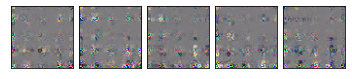

--- EPOCH 41/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
Discriminator loss: 0.00918197197218736
Generator loss:     3.2037124997768194


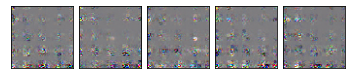

--- EPOCH 42/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
Discriminator loss: 0.10908495469225778
Generator loss:     3.120482925355374


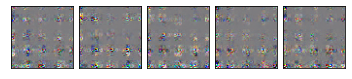

--- EPOCH 43/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
Discriminator loss: 0.02803628622657723
Generator loss:     3.1867414683037563


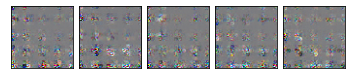

--- EPOCH 44/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
Discriminator loss: -0.008062810947497686
Generator loss:     3.254904348468095


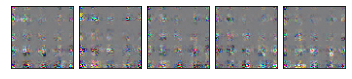

--- EPOCH 45/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
Discriminator loss: 0.03585654745499293
Generator loss:     3.343615575665189


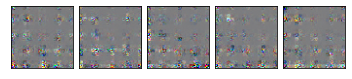

--- EPOCH 46/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
Discriminator loss: 0.11474340036511421
Generator loss:     3.364108631538021


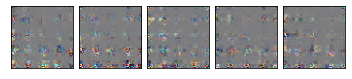

--- EPOCH 47/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
Discriminator loss: 0.06259213967455758
Generator loss:     3.465264175593046


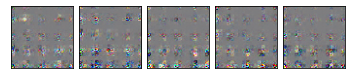

--- EPOCH 48/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
Discriminator loss: 0.08034644327643845
Generator loss:     3.400339928351698


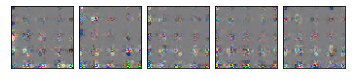

--- EPOCH 49/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
Discriminator loss: 0.05019866261217329
Generator loss:     3.372024992806425


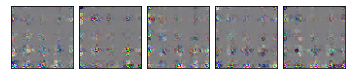

--- EPOCH 50/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
Discriminator loss: -0.013945804494950507
Generator loss:     3.3935827751001653


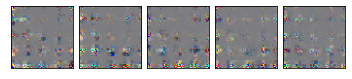

--- EPOCH 51/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
Discriminator loss: 0.020249807586272556
Generator loss:     3.28146535290245


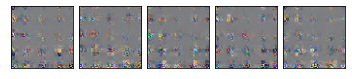

--- EPOCH 52/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
Discriminator loss: 0.09853759428693189
Generator loss:     3.4140829420419716


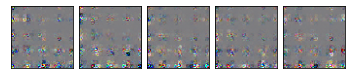

--- EPOCH 53/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
Discriminator loss: -0.015612445771694183
Generator loss:     3.4037193281601485


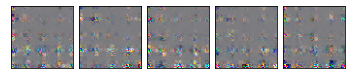

--- EPOCH 54/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
Discriminator loss: -0.03822058687607447
Generator loss:     3.4470198769780955


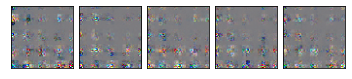

--- EPOCH 55/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
Discriminator loss: 0.13208204073210558
Generator loss:     3.570909112774006


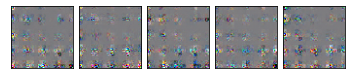

--- EPOCH 56/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.61it/s]
Discriminator loss: 0.036094170063734055
Generator loss:     3.527462984713492


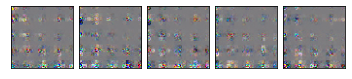

--- EPOCH 57/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.71it/s]
Discriminator loss: 0.020281699382596545
Generator loss:     3.529824982133823


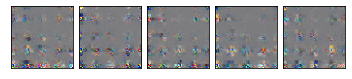

--- EPOCH 58/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
Discriminator loss: 0.03397257750233015
Generator loss:     3.6139646347813414


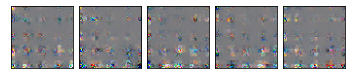

--- EPOCH 59/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
Discriminator loss: 0.05220154486596584
Generator loss:     3.530863922593127


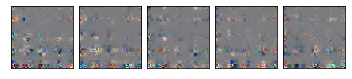

--- EPOCH 60/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.11it/s]
Discriminator loss: 0.0460523015095128
Generator loss:     3.651452782102037


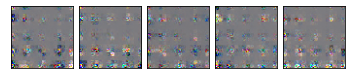

--- EPOCH 61/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
Discriminator loss: 0.0340272585550944
Generator loss:     3.693649817353906


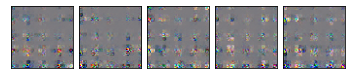

--- EPOCH 62/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.02it/s]
Discriminator loss: 0.0799926184117794
Generator loss:     3.6338300180130187


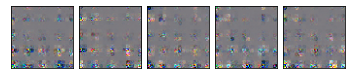

--- EPOCH 63/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
Discriminator loss: 0.08006925115154849
Generator loss:     3.555041139236119


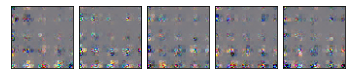

--- EPOCH 64/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
Discriminator loss: 0.06537162781589562
Generator loss:     3.683472917253612


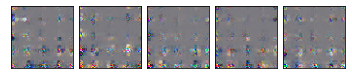

--- EPOCH 65/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
Discriminator loss: -0.027218919040428266
Generator loss:     3.6909087682250896


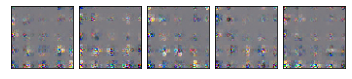

--- EPOCH 66/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
Discriminator loss: -0.060202608505884804
Generator loss:     3.5634737374478007


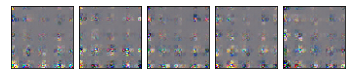

--- EPOCH 67/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
Discriminator loss: 0.09567507108052571
Generator loss:     3.7536278576649895


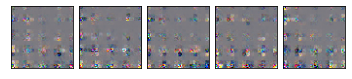

--- EPOCH 68/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
Discriminator loss: -0.01011777731279532
Generator loss:     3.731487965488787


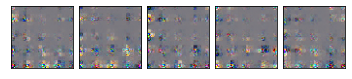

--- EPOCH 69/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
Discriminator loss: 0.11295823338958952
Generator loss:     3.6927866823059343


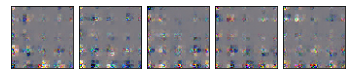

--- EPOCH 70/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.17it/s]
Discriminator loss: 0.048816422621409096
Generator loss:     3.202392049891411


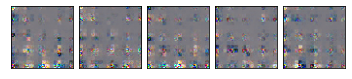

--- EPOCH 71/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
Discriminator loss: 8.049552281697592
Generator loss:     0.5283280759427509


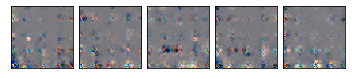

--- EPOCH 72/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
Discriminator loss: 0.7160935704078939
Generator loss:     2.2297714072761448


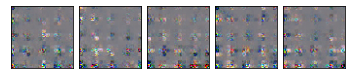

--- EPOCH 73/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
Discriminator loss: 0.11946241474813885
Generator loss:     2.9304009151877377


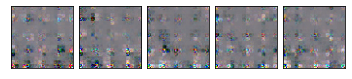

--- EPOCH 74/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
Discriminator loss: 0.12964876492818198
Generator loss:     2.961993426475038


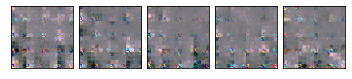

--- EPOCH 75/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.58it/s]
Discriminator loss: 0.12218740561770068
Generator loss:     3.0183934623140596


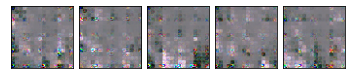

--- EPOCH 76/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
Discriminator loss: 0.11642030874888103
Generator loss:     3.165709464148483


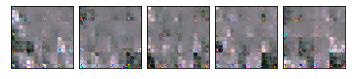

--- EPOCH 77/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.65it/s]
Discriminator loss: 0.0956796585685677
Generator loss:     3.075103852053049


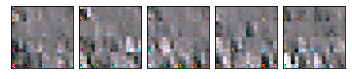

--- EPOCH 78/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
Discriminator loss: 2.0518617828687034
Generator loss:     1.6039343015113383


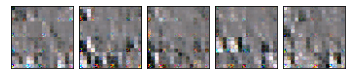

--- EPOCH 79/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
Discriminator loss: 0.6522471706072489
Generator loss:     1.6062148734746087


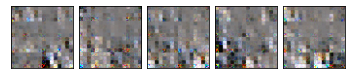

--- EPOCH 80/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
Discriminator loss: 0.5749308202001784
Generator loss:     1.7369612897110374


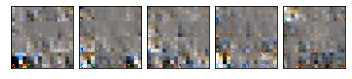

--- EPOCH 81/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.02it/s]
Discriminator loss: 0.5684423446655273
Generator loss:     1.8708026108597506


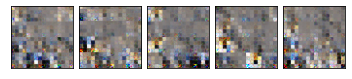

--- EPOCH 82/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.56it/s]
Discriminator loss: 1.0631505019134946
Generator loss:     1.7510597117182698


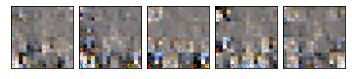

--- EPOCH 83/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
Discriminator loss: 0.18319615224997202
Generator loss:     2.8194241831533144


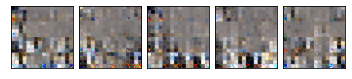

--- EPOCH 84/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.1585316587653425
Generator loss:     3.011764582654013


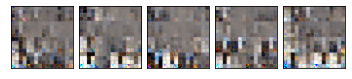

--- EPOCH 85/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.95it/s]
Discriminator loss: 0.16231389592091242
Generator loss:     3.107126187282069


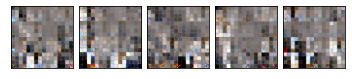

--- EPOCH 86/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
Discriminator loss: 1.8832133346133761
Generator loss:     1.7970090941743524


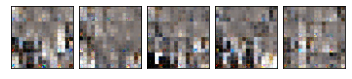

--- EPOCH 87/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
Discriminator loss: 0.2604010949532191
Generator loss:     2.6426060742288326


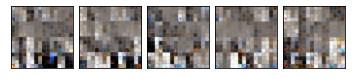

--- EPOCH 88/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.07it/s]
Discriminator loss: 0.2673817492193646
Generator loss:     2.7181404421701805


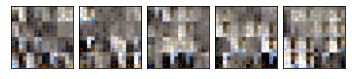

--- EPOCH 89/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
Discriminator loss: 0.31066320339838666
Generator loss:     2.4490899208131243


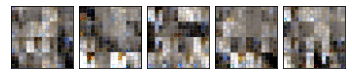

--- EPOCH 90/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
Discriminator loss: 1.0546132657263014
Generator loss:     2.0424094913804223


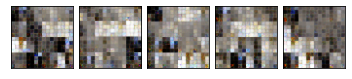

--- EPOCH 91/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
Discriminator loss: 0.2697107212411033
Generator loss:     2.449173294257867


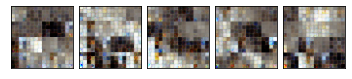

--- EPOCH 92/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
Discriminator loss: 0.2996571742826038
Generator loss:     2.404064859809018


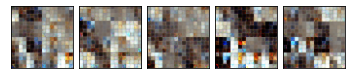

--- EPOCH 93/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
Discriminator loss: 0.3985615008407169
Generator loss:     2.1769896043323183


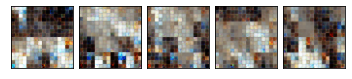

--- EPOCH 94/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
Discriminator loss: 0.4069351984394921
Generator loss:     2.166554237382159


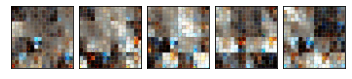

--- EPOCH 95/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.73it/s]
Discriminator loss: 0.3192906677722931
Generator loss:     2.2910833824235226


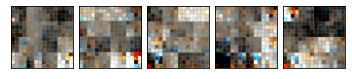

--- EPOCH 96/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
Discriminator loss: 0.7360038045379851
Generator loss:     1.9650770108758724


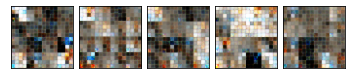

--- EPOCH 97/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
Discriminator loss: 0.39850085973739624
Generator loss:     2.2751607092172375


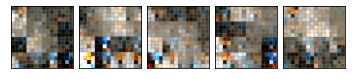

--- EPOCH 98/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
Discriminator loss: 0.5643500039974848
Generator loss:     1.979978177542168


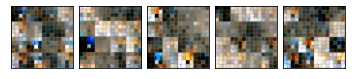

--- EPOCH 99/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
Discriminator loss: 0.3278989725642734
Generator loss:     2.269452527326914


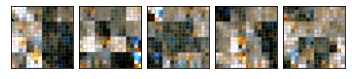

--- EPOCH 100/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.70it/s]
Discriminator loss: 0.3533198783795039
Generator loss:     2.3232380048385632


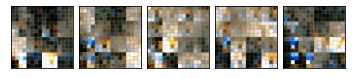

In [104]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


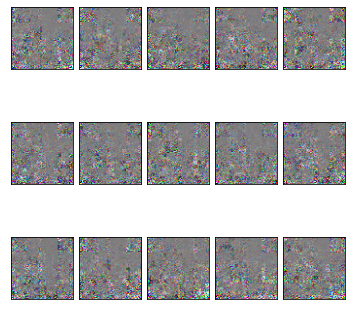

In [99]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [100]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [101]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [102]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [103]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

